In [1]:
import os
from typing import Optional
from smolagents import CodeAgent, LiteLLMModel, tool
from PIL import Image
import io
import base64

# Create a custom tool for processing images
@tool
def process_image(image_base64: str, question: str) -> str:
    """
    Process an image and answer a question about it.
    
    Args:
        image_base64: Base64 encoded image data
        question: The question about the image
        
    Returns:
        A text response answering the question about the image
    """
    try:
        # In a real implementation, you would:
        # 1. Decode the base64 image
        image_data = base64.b64decode(image_base64)
        image = Image.open(io.BytesIO(image_data))
        
        # 2. Here you would normally use a vision model to analyze the image
        # For this example, we'll just acknowledge receiving the image
        image_info = f"Received image: {image.size[0]}x{image.size[1]} pixels"
        
        return f"Image info: {image_info}\nQuestion: {question}\nThis is a placeholder response. In a real implementation, a vision model would analyze the image and answer the question."
    
    except Exception as e:
        return f"Error processing image: {str(e)}"

@tool
def answer_query(query: str) -> str:
    """
    Answer a general query from the user.
    
    Args:
        query: The user's question
        
    Returns:
        A text response answering the user's question
    """
    return f"You asked: {query}\nThis is a placeholder response. In a real implementation, the agent would provide a meaningful answer."


In [ ]:
model = LiteLLMModel(
        model_id="ollama/qwen2.5vl:7b",
        temperature=0.2
    )
agent = CodeAgent(
        tools=[xxx],
        model=model,
    )

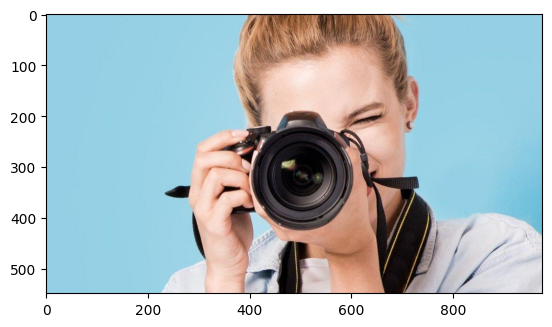

In [21]:
import matplotlib.pyplot as plt
from PIL import Image

# img = Image.new('RGB', (10, 10), color='red')
img = Image.open('test_image.jpg')
plt.imshow(img)

In [28]:
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage
from PIL import Image
import base64
import io
from rich import print as rprint

class LangChainOllamaModel:
    def __init__(self, model_id="qwen2.5vl:7b", temperature=0.2, num_ctx=8196):
        self.model_id = model_id
        self.temperature = temperature
        self.num_ctx = num_ctx
        # Initialize the ChatOllama model
        self.chat_model = ChatOllama(
            model=model_id,
            temperature=temperature,
            num_ctx=num_ctx,
            # format="json"  # Ensure we get a structured response
        )
    
    def encode_image_to_base64(self, image_path):
        """
        Encode an image file to base64 string
        """
        try:
            img = Image.open(image_path)
            return self.process_pil_image(img)
        except Exception as e:
            print(f"Error loading image from path: {e}")
            return None
    
    def process_pil_image(self, pil_image):
        """
        Convert a PIL Image to base64 string
        """
        try:
            buffered = io.BytesIO()
            # Always save as JPEG for compatibility
            if pil_image.mode != 'RGB':
                pil_image = pil_image.convert('RGB')
            pil_image.save(buffered, format="JPEG")
            return base64.b64encode(buffered.getvalue()).decode('utf-8')
        except Exception as e:
            print(f"Error processing image: {e}")
            return None
    
    def generate_response(self, prompt, image_path=None, pil_image=None):
        """
        Generate a response from the model for text or image+text input
        
        Args:
            prompt (str): The text prompt
            image_path (str, optional): Path to an image file
            pil_image (PIL.Image, optional): A PIL Image object
            
        Returns:
            str: Model response
        """
        try:
            # Check if we have image input
            if image_path or pil_image:
                # Prepare image data
                if image_path:
                    image_base64 = self.encode_image_to_base64(image_path)
                elif pil_image:
                    image_base64 = self.process_pil_image(pil_image)
                
                if not image_base64:
                    return "Error: Failed to process the image."
                
                # Create message with image content using LangChain's format
                message = HumanMessage(
                    content=[
                        {
                            "type": "text", 
                            "text": prompt
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{image_base64}"
                            }
                        }
                    ]
                )
                
                # Call the model with the message
                response = self.chat_model.invoke([message])
                return response.content
                
            else:
                # Text-only input
                message = HumanMessage(content=prompt)
                response = self.chat_model.invoke([message])
                return response.content
                
        except Exception as e:
            return f"Error generating response: {str(e)}"

# Example usage:
if __name__ == "__main__":
    # Note: For Ollama models, you typically don't include the "ollama/" prefix when using langchain
    model = LangChainOllamaModel(model_id="qwen2.5vl:7b", temperature=0.2)
    
    # Text-only query example
    rprint("\nTesting text-only query...")
    try:
        response = model.generate_response("What is the capital of France?")
        rprint(response)
    except Exception as e:
        rprint(f"Error with text query: {e}")
    
    # Image query with file path
    rprint("\nTesting image query with file path...")
    try:
        response = model.generate_response(
            "What is shown in this image? Please describe it in detail.", 
            image_path="test_image.jpg"
        )
        rprint(response)
    except Exception as e:
        rprint(f"Error with file path test: {e}")
    
    # Image query with PIL Image
    rprint("\nTesting image query with PIL Image...")
    try:
        img = Image.open("test_image.jpg")
        response = model.generate_response(
            "What is shown in this image? Please describe it in detail.", 
            pil_image=img
        )
        rprint(response)
    except Exception as e:
        rprint(f"Error with PIL image test: {e}")

Testing text-only query...

The capital of France is Paris.

Testing image query with file path...

The image shows a person taking a photograph with a professional camera. The individual is holding the camera up to
their face, with the camera lens pointed directly at the viewer. The person has light-colored hair tied back in a 
bun and is wearing a light blue shirt. The background is a solid light blue color, which provides a simple and 
uncluttered backdrop. The camera appears to be a DSLR or mirrorless model, with a large lens attached, suggesting 
it is designed for photography that requires a wide field of view or a high level of detail. The person's 
expression is focused, indicating concentration on capturing the perfect shot. The overall image conveys a sense of
creativity and passion for photography.

Testing image query with PIL Image...

The image shows a person holding a camera up to their face, seemingly taking a photograph. The camera appears to be
a professional DSLR model, with a large lens attached. The person is wearing a light-colored shirt and has their 
hair tied back. The background is a solid light blue color, which provides a simple and clean backdrop. The 
person's expression is focused, and they are looking through the viewfinder of the camera. The lighting in the 
image is bright and even, highlighting the details of the camera and the person's face.

In [31]:
from smolagents import CodeAgent, tool
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage
from PIL import Image
import base64
import io
import os
import json
from typing import Optional, Dict, Any, List, Union
from rich import print as rprint

class EnhancedVLAgent:
    """
    Enhanced Vision-Language Agent that uses smolagents for better image understanding
    with Qwen2.5vl-7b model.
    """
    def __init__(self, 
                 model_id="qwen2.5vl:7b", 
                 temperature=0.2, 
                 num_ctx=8196,
                 qa_model_id="gpt-4o"):
        """
        Initialize the enhanced agent with both VL model and QA reviewer model
        
        Args:
            model_id (str): The Ollama VL model ID
            temperature (float): Temperature for generation
            num_ctx (int): Context window size
            qa_model_id (str): Model ID for the QA reviewer agent
        """
        self.model_id = model_id
        self.temperature = temperature
        self.num_ctx = num_ctx
        
        # Initialize the ChatOllama model for direct VL interactions
        self.chat_model = ChatOllama(
            model=model_id,
            temperature=temperature,
            num_ctx=num_ctx,
        )
        
        # Initialize the QA reviewer agent using smolagents
        try:
            # Create a ChatOllama model wrapped for smolagents
            qa_model = ChatOllama(
                model=qa_model_id,
                temperature=temperature,
                num_ctx=num_ctx
            )
            
            self.qa_agent = CodeAgent(
                tools=[self.improve_image_analysis],
                model=qa_model,
                verbosity_level=1,
                stream_outputs=False
            )
        except Exception as e:
            rprint(f"[bold red]Warning: Could not initialize QA agent: {e}[/bold red]")
            rprint("[yellow]Continuing without QA agent review capabilities[/yellow]")
            self.qa_agent = None
    
    def encode_image_to_base64(self, image_path):
        """
        Encode an image file to base64 string
        """
        try:
            img = Image.open(image_path)
            return self.process_pil_image(img)
        except Exception as e:
            rprint(f"Error loading image from path: {e}")
            return None
    
    def process_pil_image(self, pil_image):
        """
        Convert a PIL Image to base64 string
        """
        try:
            buffered = io.BytesIO()
            # Always save as JPEG for compatibility
            if pil_image.mode != 'RGB':
                pil_image = pil_image.convert('RGB')
            pil_image.save(buffered, format="JPEG")
            return base64.b64encode(buffered.getvalue()).decode('utf-8')
        except Exception as e:
            rprint(f"Error processing image: {e}")
            return None
    
    @tool
    def improve_image_analysis(self, original_analysis: str) -> str:
        """
        QA tool that improves the image analysis results from the VL model.
        
        Args:
            original_analysis (str): The original analysis from the VL model
            
        Returns:
            str: Improved and enhanced analysis
        """
        system_prompt = """
        You are an expert image analysis reviewer. Your task is to enhance the image analysis 
        provided by a vision-language model. Follow these guidelines:
        
        1. Identify any vague or generic descriptions and make them more specific
        2. Ensure spatial relationships between objects are clearly described
        3. Check for any contradictions or inconsistencies and correct them
        4. Enhance the structure and clarity of the analysis
        5. Add any important details that might have been missed
        6. Remove redundant information
        7. Make sure the analysis is comprehensive yet concise
        
        Do NOT introduce new objects or elements that weren't mentioned in the original analysis
        unless you are highly confident that something significant was missed.
        
        Return the improved analysis.
        """
        
        # Since we're just using a tool within smolagents, we'll simulate the model call
        try:
            response = self.chat_model.invoke([
                SystemMessage(content=system_prompt),
                HumanMessage(content=f"Here is the original image analysis provided by a vision-language model: \n\n{original_analysis}\n\nPlease improve this analysis following the guidelines.")
            ])
            return response.content
        except Exception as e:
            return f"Error improving analysis: {str(e)}\n\nOriginal analysis: {original_analysis}"
    
    def _create_enhanced_prompt(self, prompt, task_type="general"):
        """
        Create an enhanced prompt for Qwen2.5vl based on the task type
        
        Args:
            prompt (str): The original user prompt
            task_type (str): The type of task (general, detail, ocr, counting, layout, etc.)
            
        Returns:
            str: Enhanced prompt
        """
        # Base system prompt for enhanced analysis
        base_system = "You are an advanced AI vision assistant capable of detailed image analysis. "
        
        # Task-specific enhancements
        task_specific = {
            "general": "Analyze this image thoroughly. Pay attention to objects, their relationships, colors, text, and overall composition. Be precise and detailed.",
            
            "detail": "Focus on fine details in this image. Describe textures, small objects, subtle patterns, and nuanced elements that might be easily overlooked.",
            
            "ocr": "This image contains text. Extract ALL text visible in the image with precision. Maintain the original layout and structure of the text. If there are tables, preserve their format.",
            
            "counting": "Count all instances of objects in this image accurately. Group similar items and provide exact numbers. Be methodical in your counting approach.",
            
            "layout": "Analyze the spatial layout and composition of this image. Describe the positioning of elements, their relative sizes, and the overall visual organization.",
            
            "structured": "Analyze this image and provide output in a clean, structured JSON format. Include main elements, their attributes, positions, and relationships. Format your response as valid JSON."
        }
        
        # Get the task-specific instruction or default to general
        task_instruction = task_specific.get(task_type, task_specific["general"])
        
        # Combine with the user prompt
        enhanced_prompt = f"{base_system}{task_instruction}\n\nUser query: {prompt}"
        
        return enhanced_prompt
    
    def generate_response(self, 
                          prompt, 
                          image_path=None, 
                          pil_image=None, 
                          task_type="general", 
                          review_result=True):
        """
        Generate a response from the model for text or image+text input
        
        Args:
            prompt (str): The text prompt
            image_path (str, optional): Path to an image file
            pil_image (PIL.Image, optional): A PIL Image object
            task_type (str): The type of image analysis task
            review_result (bool): Whether to run the result through the QA agent
            
        Returns:
            str: Model response
        """
        try:
            # Enhance the prompt based on task type
            enhanced_prompt = self._create_enhanced_prompt(prompt, task_type)
            
            # Check if we have image input
            if image_path or pil_image:
                # Prepare image data
                if image_path:
                    image_base64 = self.encode_image_to_base64(image_path)
                elif pil_image:
                    image_base64 = self.process_pil_image(pil_image)
                
                if not image_base64:
                    return "Error: Failed to process the image."
                
                # Create message with image content using LangChain's format
                message = HumanMessage(
                    content=[
                        {
                            "type": "text", 
                            "text": enhanced_prompt
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{image_base64}"
                            }
                        }
                    ]
                )
                
                # Call the model with the message
                response = self.chat_model.invoke([message])
                result = response.content
                
                # If QA agent is available and review is requested, review the result
                if self.qa_agent and review_result:
                    try:
                        rprint("[yellow]Reviewing the initial analysis with QA agent...[/yellow]")
                        improved_result = self.qa_agent.run(f"Review and improve this image analysis:\n\n{result}")
                        result = improved_result
                    except Exception as e:
                        rprint(f"[bold red]Error in QA review: {e}[/bold red]")
                        rprint("[yellow]Returning original analysis[/yellow]")
                
                return result
                
            else:
                # Text-only input
                message = HumanMessage(content=enhanced_prompt)
                response = self.chat_model.invoke([message])
                return response.content
                
        except Exception as e:
            return f"Error generating response: {str(e)}"


# Example usage:
if __name__ == "__main__":
    # Create an enhanced VL agent
    agent = EnhancedVLAgent(
        model_id="qwen2.5vl:7b", 
        temperature=0.2,
        qa_model_id="qwen2.5vl:7b"  # This can be any model available through Ollama
    )
    
    # Examples for different task types
    tasks = {
        "general": "What is shown in this image? Please describe it in detail.",
        "detail": "Analyze all the fine details visible in this image.",
        "ocr": "Extract and organize all text visible in this image.",
        "counting": "Count all the objects present in this image.",
        "layout": "Describe the spatial layout and composition of this image.",
        "structured": "Analyze this image and provide details in JSON format."
    }
    
    # Test with an image if available
    image_path = "test_image.jpg"
    if os.path.exists(image_path):
        for task_type, prompt in tasks.items():
            rprint(f"\n[bold green]Testing {task_type} task:[/bold green]")
            try:
                response = agent.generate_response(
                    prompt=prompt,
                    image_path=image_path,
                    task_type=task_type
                )
                rprint(f"[bold blue]Response:[/bold blue]\n{response}")
            except Exception as e:
                rprint(f"[bold red]Error with {task_type} task: {e}[/bold red]")
    else:
        rprint(f"[bold yellow]Warning: Test image not found at {image_path}[/bold yellow]")
        rprint("[bold yellow]Please provide a valid image path to test the agent[/bold yellow]")

TypeHintParsingException: Argument self is missing a type hint in function improve_image_analysis